In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import xarray as xr
from functools import reduce
import math
import cartopy.crs as crs
import pyreadr

In [134]:
class PCA:
    def __init__(self, X):
        self.sigma = np.std(X, axis=0)
        self.mu = np.mean(X, axis=0)
        self.X_std = (X - self.mu) / self.sigma
        
        self.cov_mat = self.X_std.T @ self.X_std / (self.X_std.shape[0] - 1)
        
        self.X_eofs, self.eigen_values, _ = np.linalg.svd(self.cov_mat)
        self.X_projected = np.dot(self.X_std, self.X_eofs)   
    
    def eofs(self, n_X):
        return self.X_eofs[:, 0:n_X].T
    
    def projected(self, n_X):  
        return self.X_projected[:, 0:n_X]
        
    def reconstructed(self, n_X):
        return np.dot(self.X_projected[:, 0:n_X], self.X_eofs[:, 0:n_X].T) * self.sigma[0:n_X] + self.mu[0:n_X]

    def explained_var(self):
        return self.eigen_values / np.sum(self.eigen_values)
    
    def explained_cumvar(self):
        return np.cumsum(self.eigen_values) / np.sum(self.eigen_values)

In [135]:
class MCA:
    def __init__(self, X, Y):
        self.sigma_X = np.std(X, axis=0)
        self.mu_X = np.mean(X, axis=0)
        self.X_std = (X - self.mu_X) / self.sigma_X
        
        self.sigma_Y = np.std(Y, axis=0)
        self.mu_Y = np.mean(Y, axis=0)
        self.Y_std = (Y - self.mu_Y) / self.sigma_Y
        
        self.cov_mat = self.X_std.T @ self.Y_std / (self.X_std.shape[0] - 1)
        
        self.X_eofs, self.eigen_values, self.Y_eofs = np.linalg.svd(self.cov_mat, full_matrices=False)
        self.Y_eofs = self.Y_eofs.T
        
        self.X_projected = np.dot(self.X_std, self.X_eofs)
        self.Y_projected = np.dot(self.Y_std, self.Y_eofs)
        
    def eofs(self, n_X, n_Y):
        return self.X_eofs[:, 0:n_X].T, self.Y_eofs[:, 0:n_Y].T
    
    def projected(self, n_X, n_Y):
        return self.X_projected[:, 0:n_X], self.Y_projected[:, 0:n_Y]
    
    def reconstructed(self, n_X):
        X_reconstructed = np.dot(self.X_projected[:, 0:n_X], self.X_eofs[:, 0:n_X].T) * self.sigma_X[0:n_X] + self.mu_X[0:n_X]
        Y_reconstructed = np.dot(self.Y_projected[:, 0:n_Y], self.Y_eofs[:, 0:n_Y].T) * self.sigma_Y[0:n_Y] + self.mu_Y[0:n_Y]
        return X_reconstructed, Y_reconstructed
    
    def explained_var(self):
        return self.eigen_values / np.sum(self.eigen_values)
    
    def explained_cumvar(self):
        return np.cumsum(self.eigen_values) / np.sum(self.eigen_values)

In [162]:
def near_PSD(A):
    C = (A + A.T) / 2
    eigen_val, eigen_vec = np.linalg.eigh(C)
    eigen_val[eigen_val < 0] = 0

    return np.matmul(np.matmul(eigen_vec, A), eigen_vec.T)

def take_month(time, Month):
    year = np.zeros(time.shape[0])
    month = np.zeros(time.shape[0])
    for i in range(time.shape[0]):
        ymd = time[i].rsplit("-", 2)
        year[i] = int(ymd[0])
        month[i] = int(ymd[1])

    return np.where(np.isin(month, Month))[0]

def take_month_year(time):
    year = np.zeros(time.shape[0])
    month = np.zeros(time.shape[0])
    for i in range(time.shape[0]):
        ymd = time[i].rsplit("-", 2)
        year[i] = int(ymd[0])
        month[i] = int(ymd[1])

    return month, year

def ma(x, k=3):
    res = np.zeros_like(x)
    aux = np.append(np.zeros((math.floor(k / 2), x.shape[1])) * np.nan, x, axis=0)
    for i in range(x.shape[0]):
        res[i, np.where(~np.isnan(x[i]))] = np.nanmean(aux[i:i+k, np.where(~np.isnan(x[i]))], axis=0)
        res[i, np.where(np.isnan(x[i]))] = np.nan

    return res

def ECDF_smoothing(x, k=3):
    each = np.zeros((x.shape[1], x.shape[0], k))
    for i in range(k):
        idx = np.arange(i, x.shape[0], k)
        for j in range(x.shape[1]):
            ni = np.sort(x[idx, j])[~np.isnan(np.sort(x[idx, j]))]
            if len(ni) > 0: each[j, :, i] = np.interp(x[:, j], ni, np.arange(1, ni.shape[0] + 1) / (ni.shape[0] + 1), left = 0, right = 1-1E-9)
            else: each[j, :, i] = np.nan

    return np.mean(each, axis = 2).T

def to_alpha_2(x):
    return np.sqrt(1 / - np.log(x))

def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    id_res = np.repeat(0, start.shape[0])
    for i in range(len(start)):
        temp = x.T.flatten()[start[i]:end[i] + 1]
        id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1
    
    return id_res

"""
def decls(x, th, k):
    id_big = np.where(x.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    idx = np.logical_and(np.arange(x.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
    ext_prcp = np.repeat(x.flatten()[np.newaxis, :], repeats=idx.shape[0], axis=0)[idx]
    cls_prcp = np.asarray(np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1]))
   
    return list(map(np.argmax, cls_prcp)) + start
"""

"""
def decls(x, th, k):
    # Minimum number of days to define extreme event
    n_days = 3
    # Define extreme event quantile
    thr_quantile = 0.90
    threshold = np.quantile(x, thr_quantile)
    # Use convolution with a window function of length = number of days to decluster the extreme events
    idx_extremes = np.flatnonzero(np.convolve(x >= threshold, np.ones(n_days), 'valid') >= n_days)
    # The index currently contains only the first days (start) of an extreme event
    # Add all indices for days which qualilfy as extreme
    idx_extremes = [idx_extremes + i for i in range(n_days)]
    idx_extremes = reduce(np.union1d, (idx_extremes))
    # Create a boolean index from the extreme index which we can use to
    # mask the original data
    idx_all = np.arange(len(x))
    idx_extremes = np.where(np.isin(idx_all, idx_extremes), True, False)

    return np.where(idx_extremes == True)[0]
"""

def rw_Sigma(x, u=0.98):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        if i % 100 == 0: print(i)
        for j in range(x.shape[1]):
            r = np.sqrt(x[:, i] ** 2 + x[:, j] ** 2)
            w1 = x[:, i] / r
            w2 = x[:, j] / r
            idx = decls(r, th = np.nanquantile(r, u), k = 5)
            Sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2

    return Sigma

def trans(x):
    v = np.log(1 + np.exp(x))
    v[~np.isfinite(v)] = x[~np.isfinite(v)]
    v[x < -20] = np.exp(x[x < -20])

    return v

def inv_trans(v):
    x = np.log(np.exp(v) - 1)
    idx = np.logical_and(~np.isfinite(x), ~np.isnan(x), v > 1)
    x[idx] = v[idx]

    return x

def pc_one(i, U, invX):
    idxna = np.isnan(invX[i])

    return np.matmul(U[~idxna].T, invX[i, ~idxna])

def pc(U, invX):
    res = np.zeros_like(invX)
    for i in range(invX.shape[0]):
        res[i] = pc_one(i, U, invX)

    return res

def reconstruct(V, U, k, day):
    return trans(np.matmul(U[:, 0:k], V[day, 0:k]))

In [137]:
class xPCA:   
    def __init__(self, X):
        self.X = X
        self.sigma = np.zeros((self.X.shape[1], self.X.shape[1]))

    def moving_average(self, k=3):
        res = np.zeros_like(self.X)
        aux = np.append(np.zeros((math.floor(k / 2), self.X.shape[1])) * np.nan, self.X, axis=0)
        for i in range(self.X.shape[0]):
            res[i, np.where(~np.isnan(self.X[i]))] = np.nanmean(aux[i:i+k, np.where(~np.isnan(self.X[i]))], axis=0)
            res[i, np.where(np.isnan(self.X[i]))] = np.nan

        return res

    def ECDF_smoothing(self, k=3):
        each = np.zeros((self.X.shape[1], self.X.shape[0], k))
        for i in range(k):
            idx = np.arange(i, self.X.shape[0], k)
            for j in range(self.X.shape[1]):
                ni = np.sort(self.X[idx, j])[~np.isnan(np.sort(self.X[idx, j]))]
                if len(ni) > 0: each[j, :, i] = np.interp(self.X[:, j], ni, np.arange(1, ni.shape[0] + 1) / (ni.shape[0] + 1), left = 0, right = 1-1E-9)
                else: each[j, :, i] = np.nan

        return np.mean(each, axis = 2).T

    def to_alpha_2(self):
        return np.sqrt(1 / - np.log(self.X))
    
    def preprocessing(self):
        self.X = self.moving_average()
        self.X = self.ECDF_smoothing()
        self.X = self.to_alpha_2()
        
        return self.X

    def declustering(self, x, th, k):
        id_big = np.where(x.T.flatten() > th)[0]
        start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
        end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
        id_res = np.repeat(0, start.shape[0])
        for i in range(len(start)):
            temp = x.T.flatten()[start[i]:end[i] + 1]
            id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1

        return id_res

    """
    def decls(x, th, k):
        id_big = np.where(x.flatten() > th)[0]
        start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
        end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
        idx = np.logical_and(np.arange(x.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
        ext_prcp = np.repeat(x.flatten()[np.newaxis, :], repeats=idx.shape[0], axis=0)[idx]
        cls_prcp = np.asarray(np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1]))

        return list(map(np.argmax, cls_prcp)) + start
    """

    """
    def declustering(x, th, k):
        n_days = 3 # Minimum number of days to define extreme event
        thr_quantile = 0.90 # Define extreme event quantile
        threshold = np.quantile(self.X, thr_quantile)
        
        idx_extremes = np.flatnonzero(np.convolve(x >= threshold, np.ones(n_days), 'valid') >= n_days) # Use convolution with a window function to decluster the extreme events
        idx_extremes = [idx_extremes + i for i in range(n_days)] # Add all indices for days which qualilfy as extreme
        idx_extremes = reduce(np.union1d, (idx_extremes))
        
        # Create a boolean index from the extreme index which we can use to
        # mask the original data
        idx_all = np.arange(len(self.X))
        idx_extremes = np.where(np.isin(idx_all, idx_extremes), True, False)

        return np.where(idx_extremes == True)[0]
    """

    def tpdm(self, u=0.98):
        for i in range(self.X.shape[1]):
            if i % 100 == 0: print(i)
            for j in range(self.X.shape[1]):
                r = np.sqrt(self.X[:, i] ** 2 + self.X[:, j] ** 2)
                w1 = self.X[:, i] / r
                w2 = self.X[:, j] / r
                idx = self.declustering(r, th = np.nanquantile(r, u), k = 5)
                self.sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2

        return self.sigma

    def trans(self):
        v = np.log(1 + np.exp(self.X))
        v[~np.isfinite(v)] = self.X[~np.isfinite(v)]
        v[self.X < -20] = np.exp(self.X[self.X < -20])

        return v

    def inv_trans(self, v):
        self.X = np.log(np.exp(v) - 1)
        idx = np.logical_and(~np.isfinite(self.X), ~np.isnan(self.X), v > 1)
        self.X[idx] = v[idx]

        return self.X

    def pc_one(self, i, U, invX):
        idxna = np.isnan(invX[i])

        return np.matmul(U[~idxna].T, invX[i, ~idxna])

    def pc(self, U, invX):
        res = np.zeros_like(invX)
        for i in range(invX.shape[0]):
            res[i] = self.pc_one(i, U, invX)

        return res

    def reconstruct(V, U, k, day):
        return trans(np.matmul(U[:, 0:k], V[day, 0:k]))

### Understanding Principal Component Analysis

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

x = df.iloc[:,0:4]
target = df.iloc[:,4] 
pca = PCA(x)
projected = pca.projected(n_X=2)
 
pca_df = pd.DataFrame(projected , columns = ['PC1','PC2']) 
pca_df = pd.concat([pca_df , pd.DataFrame(target)] , axis = 1)

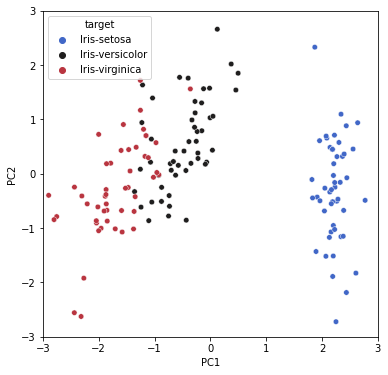

In [7]:
plt.figure(figsize = (6,6))
sb.scatterplot(data = pca_df, x='PC1', y='PC2', hue='target', s=30, palette='icefire')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

### E-OBS gridded dataset

In [8]:
file = '/Users/miguel/Desktop/fisica_mates/cinque/tfg-xpca/data/rr_ens_mean_0.25deg_reg_v21.0e.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:    (longitude: 464, latitude: 201, time: 25567)
Coordinates:
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2019-12-31
Data variables:
    rr         (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.3 (http://code.zmaw.de/p...
    history:      Mon Jun 08 10:20:53 2020: cdo -z zip_2 mergetime rr_day_201...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.6.3 (http://code.zmaw.de/p...

### Europe

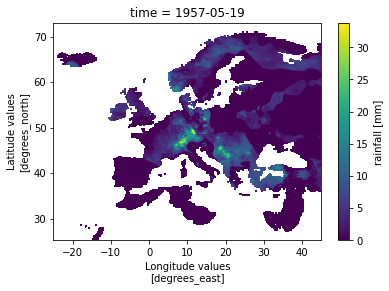

In [9]:
europe = ds.sel(time='1957-05-19', latitude=slice(25, 73), longitude=slice(-25, 45)).rr.plot() # region of Europe
plt.show()

#### *(Principal Component Analysis).* Europe Precipitation during Cold Drop Season

In [ ]:
europe = ds.sel(latitude=slice(25, 73), longitude=slice(-25, 45)) # region of Europe
europe_prcp = europe.stack(x=('latitude', 'longitude')).rr
europe_notnan_idx = europe_prcp.notnull().all(axis=0)
europe_prcp = europe_prcp[:, europe_notnan_idx]
europe_std_idx = europe_prcp.std('time') > 1e-8
europe_prcp = europe_prcp[:, europe_std_idx]

df_europe = europe_prcp.to_dataframe()
obs = pd.DataFrame(df_europe.droplevel(level=[1,2]).values.reshape(europe_prcp.time.shape[0], europe_prcp.x.shape[0]))

dana_id = take_month(np.datetime_as_string(europe_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = europe_prcp.time.values[dana_id]
europe_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Europe

pca = pca(n_components=1000)
europe_dana_projected = pca.fit_transform(europe_data_dana.values)
europe_dana_eofs = pca.components_

da = xr.DataArray(europe_dana_eofs, dims=['mode', 'x'], coords={'x': europe_prcp.coords['x'], 'mode': range(1, europe_dana_eofs.shape[0] + 1)})
da = da.unstack().sortby(['longitude', 'latitude'])

In [ ]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 7
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-25, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(range(len(europe_data_dana.index)), europe_dana_projected[:, mode - 1])
ax2.set_title('mode = 7')
plt.show()

In [ ]:
rec_alldays = np.dot(europe_dana_projected, europe_dana_eofs)
xrec_alldays = xr.DataArray(rec_alldays, dims=['time', 'x'], coords={'x': europe_prcp.coords['x'], 'time': europe.time[europe.time.dt.month.isin([7, 8, 9, 10, 11])].values})
xrec_alldays = xrec_alldays.unstack().sortby(['longitude', 'latitude'])

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

europe_prcp.sel(time='1987-11-03').unstack().sortby(['latitude', 'longitude']).plot(ax=ax1, vmin=0) # original data
xrec_alldays.sel(time='1987-11-03').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of original data
plt.show()

#### *(Principal Component Analysis).* Europe Precipitation during Cold Drop Season (for transformed data)

In [ ]:
europe = ds.sel(latitude=slice(25, 73), longitude=slice(-25, 45)) # region of Europe
europe_prcp = europe.stack(x=('latitude', 'longitude')).rr
europe_notnan_idx = europe_prcp.notnull().all(axis=0)
europe_prcp = europe_prcp[:, europe_notnan_idx]
europe_std_idx = europe_prcp.std('time') > 1e-8
europe_prcp = europe_prcp[:, europe_std_idx]

df_europe = europe_prcp.to_dataframe()
obs = pd.DataFrame(df_europe.droplevel(level=[1,2]).values.reshape(europe_prcp.time.shape[0], europe_prcp.x.shape[0]))

dana_id = take_month(np.datetime_as_string(europe_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = europe_prcp.time.values[dana_id]
europe_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Europe

europe_dana_ave = ma(europe_data_dana.values, k=3) # 3-day moving average
europe_dana_smo = ECDF_smoothing(europe_dana_ave, k=3) # ECDF smoothing
europe_dana_tran = to_alpha_2(europe_dana_smo) # Transfer the margins to have the same regular variation index: 2

pca = PCA(n_components=1000)
europe_dana_trans_projected = pca.fit_transform(europe_dana_tran)
europe_dana_trans_eofs = pca.components_

da = xr.DataArray(europe_dana_trans_eofs, dims=['mode', 'x'], coords={'x': europe_prcp.coords['x'], 'mode': range(1, europe_dana_trans_eofs.shape[0] + 1)})
da = da.unstack().sortby(['longitude', 'latitude'])

In [ ]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 3
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(range(len(europe_data_dana.index)), europe_dana_trans_projected[:, mode - 1])
ax2.set_title('mode = 3')
plt.show()

In [ ]:
xdana_tran = xr.DataArray(europe_dana_tran, dims=['time', 'x'], coords={'time': dana_date, 'x': europe_prcp.coords['x']}).unstack()

rec_alldays = np.dot(europe_dana_trans_projected, europe_dana_trans_eofs)
xrec_alldays = xr.DataArray(rec_alldays, dims=['time', 'x'], coords={'x': europe_prcp.coords['x'], 'time': europe.time[europe.time.dt.month.isin([7, 8, 9, 10, 11])].values})
xrec_alldays = xrec_alldays.unstack().sortby(['longitude', 'latitude'])

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_tran.sel(time='1987-11-03').sortby(['latitude', 'longitude']).plot(ax=ax1) # transformed precipitation data
xrec_alldays.sel(time='1987-11-03').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of transformed precipitation
plt.show()

### Spain

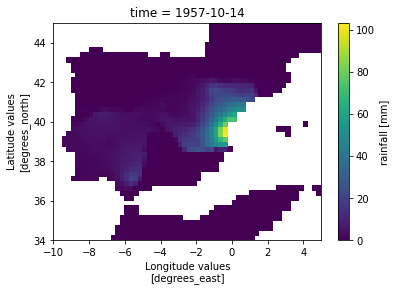

In [138]:
spain = ds.sel(time='1957-10-14', latitude=slice(34, 45), longitude=slice(-10, 5)).rr.plot() # region of Spain
plt.show()

#### *(Principal Component Analysis).* Spain Precipitation during Cold Drop Season (for moving averaged data)

In [147]:
spain = ds.sel(latitude=slice(34, 45), longitude=slice(-10, 5)) # region of Spain
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
spain_notnan_idx = spain_prcp.notnull().all(axis=0)
spain_prcp = spain_prcp[:, spain_notnan_idx]
spain_std_idx = spain_prcp.std('time') > 1e-8
spain_prcp = spain_prcp[:, spain_std_idx]

df_spain = spain_prcp.to_dataframe()
obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))

dana_id = take_month(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = spain_prcp.time.values[dana_id]
spain_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Spain

spain_dana_ave = ma(spain_data_dana.values, k=3) # 3-day moving average

pca = PCA(spain_dana_ave)
spain_dana_ma_projected = pca.projected(n_X=spain_dana_ave.shape[1])
spain_dana_ma_eofs = pca.eofs(n_X=spain_dana_ave.shape[1])
spain_dana_ma_reconstructed = pca.reconstructed(n_X=spain_dana_ave.shape[1])

da = xr.DataArray(spain_dana_ma_eofs, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, spain_dana_ma_eofs.shape[0] + 1)})
da = da.unstack().sortby(['longitude', 'latitude'])

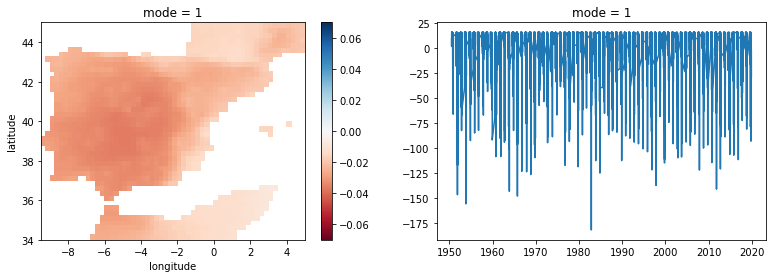

In [150]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 1
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(dana_date, spain_dana_ma_projected[:, mode - 1])
ax2.set_title('mode = {:}'.format(mode))
plt.show()

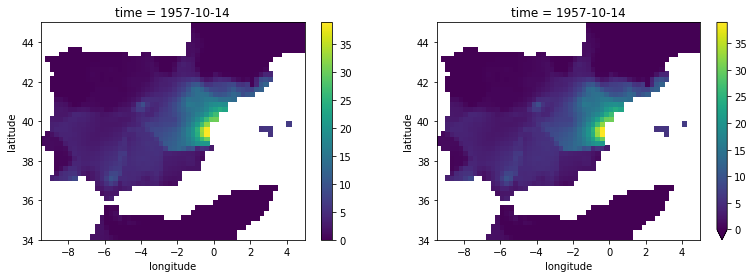

In [149]:
xdana_ma = xr.DataArray(spain_dana_ave, dims=['time', 'x'], coords={'time': dana_date, 'x': spain_prcp.coords['x']}).unstack()

xrec_alldays = xr.DataArray(spain_dana_ma_reconstructed, dims=['time', 'x'], coords={'x': spain_prcp.coords['x'], 'time': spain.time[spain.time.dt.month.isin([7, 8, 9, 10, 11])].values})
xrec_alldays = xrec_alldays.unstack().sortby(['longitude', 'latitude'])

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_ma.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax1) # original data
xrec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of original data
plt.show()

#### *(Extreme Principal Component Analysis).* Spain Precipitation during Cold Drop Season 

In [183]:
spain = ds.sel(latitude=slice(34, 45), longitude=slice(-10, 4)) # region of Spain
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
spain_notnan_idx = spain_prcp.notnull().all(axis=0) # maybe I should avoid this, as the PCA for extrems code does not complain with nan
spain_prcp = spain_prcp[:, spain_notnan_idx]
spain_std_idx = spain_prcp.std('time') > 1e-8
spain_prcp = spain_prcp[:, spain_std_idx]

df_spain = spain_prcp.to_dataframe()
obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))

## Code for computing Tail Pairwise Dependence Matrix (TPDM)

## For Cold Drop (DANA) season data (July, August, September, October, November). Calculate TPDM, its eigen decomposition 
## and other quantities like principal components

dana_id = take_month(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = spain_prcp.time.values[dana_id]
spain_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Spain

spain_dana_ave = ma(spain_data_dana.values, k=3) # 3-day moving average
spain_dana_smo = ECDF_smoothing(spain_dana_ave, k=3) # ECDF smoothing
spain_dana_tran = to_alpha_2(spain_dana_smo) # Transfer the margins to have the same regular variation index: 2

In [ ]:
spain_sigma_dana = rw_Sigma(spain_dana_tran) # Compute the TPDM
eigen_val, eigen_vec = np.linalg.eigh(spain_sigma_dana) # Eigen decomposition of TPDM
idx = np.argsort(eigen_val)[::-1] # Sort eigenvalues and eigenvectors in ascending order
eigen_val = eigen_val[idx]
eigen_vec = eigen_vec[:, idx]
sign_eigenvectors = np.sign(eigen_vec[0, :])
eigen_vec *= sign_eigenvectors

U_spain_dana = - eigen_vec # Basis vectors for PCA of TPDM
spain_dana_tran_inv = inv_trans(spain_dana_tran) # Inverse transformation
V_spain_dana = pc(U_spain_dana, spain_dana_tran_inv) # Each column is a principal component
N = V_spain_dana.shape[0]

##########################################################################################################
##########################################################################################################

## To plot basis vectors and reconstructions
long_dana = spain_prcp.unstack().longitude.shape[0]
lat_dana = spain_prcp.unstack().latitude.shape[0]

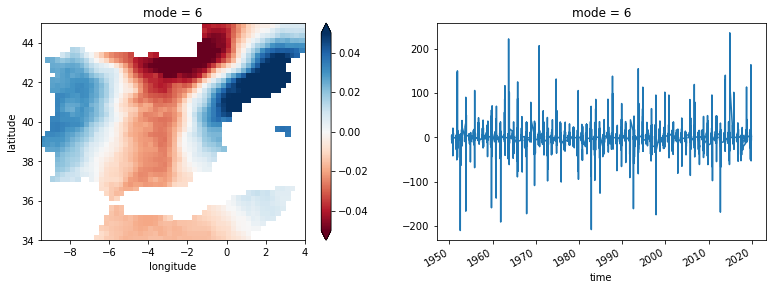

In [99]:
xU_dana = xr.DataArray(U_spain_dana, dims=['x', 'mode'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, U_spain_dana.shape[0] + 1)}).unstack()
xV_dana = xr.DataArray(V_spain_dana, dims=['time', 'mode'], coords={'time': dana_date, 'mode': range(1, V_spain_dana.shape[1] + 1)}).unstack()

rec = reconstruct(V_spain_dana, U_spain_dana, U_spain_dana.shape[0], 1)
xrec = xr.DataArray(rec, dims=['x'], coords={'x': spain_prcp.coords['x']}).unstack().sortby('longitude')

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 5
xU_dana.sortby(['longitude', 'latitude']).isel(mode=mode).plot(ax=ax1, cmap='RdBu', vmin=-0.05, vmax=0.05)
xV_dana.isel(mode=mode).plot(ax=ax2)

plt.show()

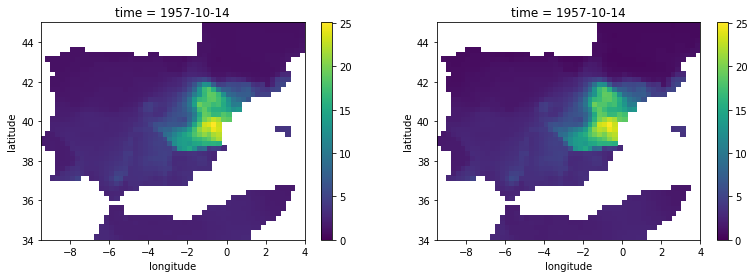

In [100]:
xdana_tran = xr.DataArray(spain_dana_tran, dims=['time', 'x'], coords={'time': dana_date, 'x': spain_prcp.coords['x']}).unstack()

rec_alldays = xU_dana.dot(xV_dana)
rec_alldays_notnan = rec_alldays.stack(x=('latitude', 'longitude')).dropna('x') # daily precipitation over Spain

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_tran.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax1, vmin=0) # original data
rec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction
plt.show()

In [22]:
#Save data, as it takes too much time to compile the code
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-spain_dana_tran.RData", pd.DataFrame(spain_dana_tran), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-spain_sigma_dana.RData", pd.DataFrame(spain_sigma_dana), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-U_spain_dana.RData", pd.DataFrame(U_spain_dana), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-V_spain_dana.RData", pd.DataFrame(V_spain_dana), compress="gzip")

In [184]:
spain_dana_tran = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-spain_dana_tran.RData")).values[0].astype(float).values
spain_sigma_dana = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-spain_sigma_dana.RData")).values[0].astype(float).values
U_spain_dana = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-U_spain_dana.RData")).values[0].astype(float).values
V_spain_dana = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-V_spain_dana.RData")).values[0].astype(float).values

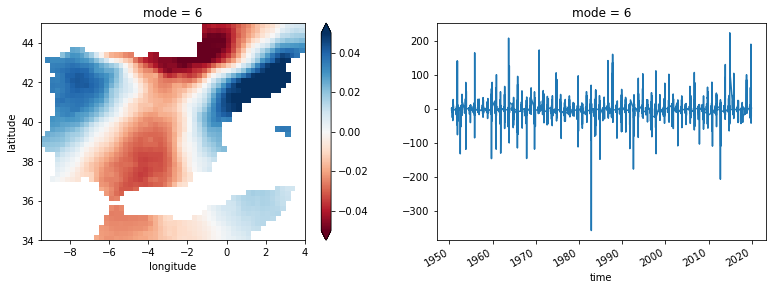

In [185]:
xU_dana = xr.DataArray(U_spain_dana, dims=['x', 'mode'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, U_spain_dana.shape[0] + 1)}).unstack()
xV_dana = xr.DataArray(V_spain_dana, dims=['time', 'mode'], coords={'time': dana_date, 'mode': range(1, V_spain_dana.shape[1] + 1)}).unstack()

rec = reconstruct(V_spain_dana, U_spain_dana, U_spain_dana.shape[0], 1)
xrec = xr.DataArray(rec, dims=['x'], coords={'x': spain_prcp.coords['x']}).unstack().sortby('longitude')

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 5
xU_dana.sortby(['longitude', 'latitude']).isel(mode=mode).plot(ax=ax1, cmap='RdBu', vmin=-0.05, vmax=0.05)
xV_dana.isel(mode=mode).plot(ax=ax2)

plt.show()

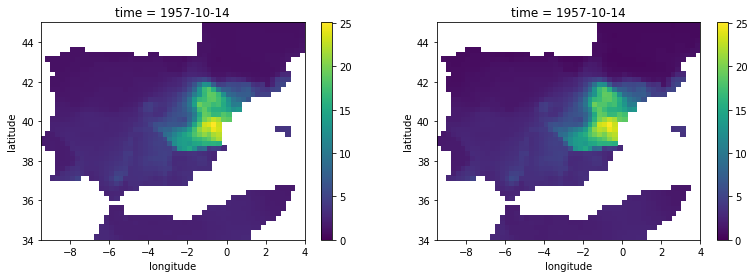

In [186]:
xdana_tran = xr.DataArray(spain_dana_tran, dims=['time', 'x'], coords={'time': dana_date, 'x': spain_prcp.coords['x']}).unstack()

rec_alldays = xU_dana.dot(xV_dana)
rec_alldays_notnan = rec_alldays.stack(x=('latitude', 'longitude')).dropna('x') # daily precipitation over Spain

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_tran.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax1, vmin=0) # original data
rec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction
plt.show()

### Valencia

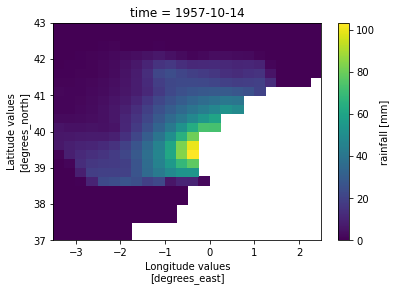

In [192]:
vlc = ds.sel(latitude=slice(37, 43), longitude=slice(-3.5, 2.5)).sel(time='1957-10-14').rr.plot() # region of Valencia
plt.show()

#### *(Principal Component Analysis).* Valencia Precipitation during Cold Drop Season (for moving averaged data)

In [255]:
vlc = ds.sel(latitude=slice(37, 43), longitude=slice(-3.5, 2.5))
vlc_prcp = vlc.stack(x=('latitude', 'longitude')).rr # other option: vlc_prcp = vlc_prcp.sel(time=vlc.time[vlc.time.dt.month.isin([7, 8, 9, 10, 11])])
vlc_notnan_idx = vlc_prcp.notnull().all(axis=0)
vlc_prcp = vlc_prcp[:, vlc_notnan_idx]
vlc_std_idx = vlc_prcp.std('time') > 1e-8
vlc_prcp = vlc_prcp[:, vlc_std_idx]

df_vlc = vlc_prcp.to_dataframe()
obs = pd.DataFrame(df_vlc.droplevel(level=[1,2]).values.reshape(vlc_prcp.time.shape[0], vlc_prcp.x.shape[0]))

dana_id = take_month(np.datetime_as_string(vlc_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))#
dana_date = vlc_prcp.time.values[dana_id]
vlc_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Spain

vlc_dana_ave = ma(vlc_data_dana.values, k=3) # 3-day moving average

pca = PCA(vlc_dana_ave)
vlc_dana_ma_projected = pca.projected(n_X=vlc_dana_ave.shape[1])
vlc_dana_ma_eofs = pca.eofs(n_X=vlc_dana_ave.shape[1])
vlc_dana_ma_reconstructed = pca.reconstructed(n_X=vlc_dana_ave.shape[1])

da = xr.DataArray(vlc_dana_ma_eofs, dims=['mode', 'x'], coords={'x': vlc_prcp.coords['x'], 'mode': range(1, vlc_dana_ma_eofs.shape[0] + 1)})
da = da.unstack().sortby(['longitude', 'latitude'])

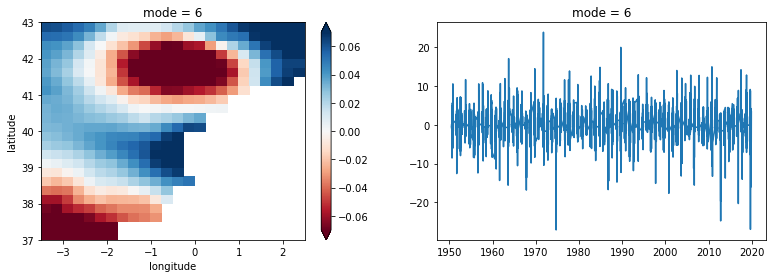

In [259]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 6
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(dana_date, vlc_dana_ma_projected[:, mode - 1])
ax2.set_title('mode = {:}'.format(mode))
plt.show()

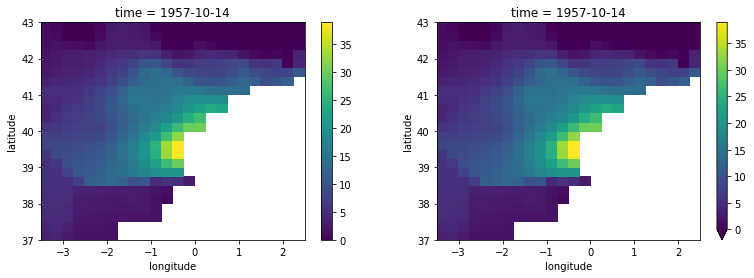

In [261]:
xdana_tran = xr.DataArray(vlc_dana_ave, dims=['time', 'x'], coords={'time': dana_date, 'x': vlc_prcp.coords['x']}).unstack()

xrec_alldays = xr.DataArray(vlc_dana_ma_reconstructed, dims=['time', 'x'], coords={'x': vlc_prcp.coords['x'], 'time': vlc.time[vlc.time.dt.month.isin([7, 8, 9, 10, 11])].values})
xrec_alldays = xrec_alldays.unstack().sortby(['longitude', 'latitude'])

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_tran.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax1) # transformed precipitation data
xrec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of transformed precipitation
plt.show()

#### *(Extreme Principal Component Analysis).* Valencia Precipitation during Cold Drop Season

In [174]:
vlc = ds.sel(latitude=slice(37, 43), longitude=slice(-3.5, 2.5)) # region of Spain
vlc_prcp = vlc.stack(x=('latitude', 'longitude')).rr
vlc_notnan_idx = vlc_prcp.notnull().all(axis=0) 
vlc_prcp = vlc_prcp[:, vlc_notnan_idx]
vlc_std_idx = vlc_prcp.std('time') > 1e-8
vlc_prcp = vlc_prcp[:, vlc_std_idx]

df_vlc = vlc_prcp.to_dataframe()
obs = pd.DataFrame(df_vlc.droplevel(level=[1,2]).values.reshape(vlc_prcp.time.shape[0], vlc_prcp.x.shape[0]))

In [175]:
## Code for computing Tail Pairwise Dependence Matrix (TPDM)

## For Cold Drop (DANA) season data (July, August, September, October, November). Calculate TPDM, its eigen decomposition 
## and other quantities like principal components

dana_id = take_month(np.datetime_as_string(vlc_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = vlc_prcp.time.values[dana_id]
vlc_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold seasons in Spain

xpca = xPCA(vlc_data_dana.values)
#vlc_dana_ave = ma(vlc_data_dana.values, k=3) # 3-day moving average
#vlc_dana_smo = ECDF_smoothing(vlc_dana_ave, k=3) # ECDF smoothing
#vlc_dana_tran = to_alpha_2(vlc_dana_smo) # Transfer the margins to have the same regular variation index: 2
vlc_dana_tran = xpca.preprocessing() 

vlc_sigma_dana = rw_Sigma(vlc_dana_tran) # Compute the TPDM
eigen_val, eigen_vec = np.linalg.eigh(vlc_sigma_dana) # Eigen decomposition of TPDM
idx = np.argsort(eigen_val)[::-1] # Sort eigenvalues and eigenvectors in ascending order
eigen_val = eigen_val[idx]
eigen_vec = eigen_vec[:, idx]
sign_eigenvectors = np.sign(eigen_vec[0, :])
eigen_vec *= sign_eigenvectors

U_vlc_dana = - eigen_vec # Basis vectors for PCA of the TPDM
vlc_dana_tran_inv = xpca.inv_trans(vlc_dana_tran) # Inverse transformation
V_vlc_dana = xpca.pc(U_vlc_dana, vlc_dana_tran_inv) # Each column is a principal component
#N = V_vlc_dana.shape[0]

##########################################################################################################
##########################################################################################################

## To plot basis vectors and reconstructions
long_dana = vlc_prcp.unstack().longitude.shape[0]
lat_dana = vlc_prcp.unstack().latitude.shape[0]

0
100
200
300


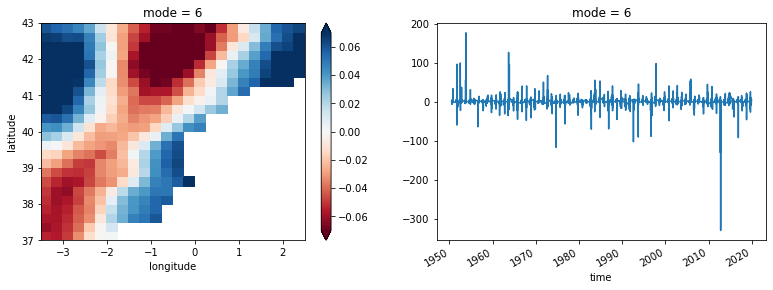

In [267]:
xU_dana = xr.DataArray(U_vlc_dana, dims=['x', 'mode'], coords={'x': vlc_prcp.coords['x'], 'mode': range(1, U_vlc_dana.shape[0] + 1)}).unstack()
xV_dana = xr.DataArray(V_vlc_dana, dims=['time', 'mode'], coords={'time': dana_date, 'mode': range(1, V_vlc_dana.shape[1] + 1)}).unstack()

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 5
xU_dana.sortby(['latitude', 'longitude']).isel(mode=mode).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
xV_dana.isel(mode=mode).plot(ax=ax2)
plt.show()

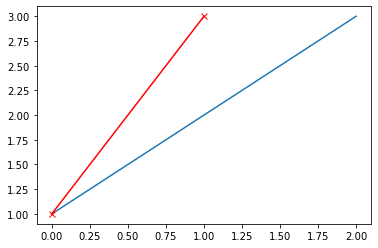

In [283]:
plt.plot([1, 2, 3])
plt.plot([1,3], marker="x", c='red')

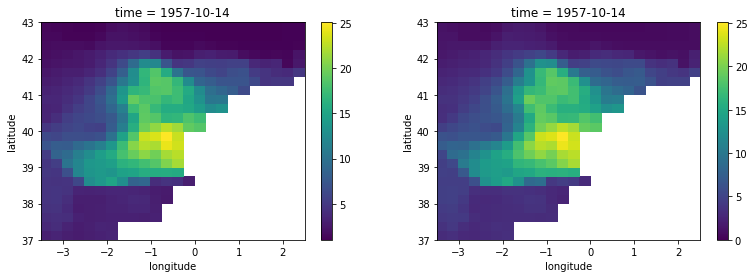

In [177]:
xdana_tran = xr.DataArray(vlc_dana_tran, dims=['time', 'x'], coords={'time': dana_date, 'x': vlc_prcp.coords['x']}).unstack()

rec_alldays = xU_dana.dot(xV_dana)
rec_alldays_notnan = rec_alldays.stack(x=('latitude', 'longitude')).dropna('x') # daily precipitation over Spain

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_tran.sel(time='1957-10-14').plot(ax=ax1) # original data
rec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction
plt.show()

In [178]:
#Save data, as it takes too much time to compile the code
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-vlc_dana_tran.RData", pd.DataFrame(vlc_dana_tran), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-vlc_sigma_dana.RData", pd.DataFrame(vlc_sigma_dana), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-U_vlc_dana.RData", pd.DataFrame(U_vlc_dana), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-V_vlc_dana.RData", pd.DataFrame(V_vlc_dana), compress="gzip")

In [179]:
vlc_dana_tran = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-vlc_dana_tran.RData")).values[0].astype(float).values
vlc_sigma_dana = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-vlc_sigma_dana.RData")).values[0].astype(float).values
U_vlc_dana = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-U_vlc_dana.RData")).values[0].astype(float).values
V_vlc_dana = pd.Series(pyreadr.read_r("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-V_vlc_dana.RData")).values[0].astype(float).values

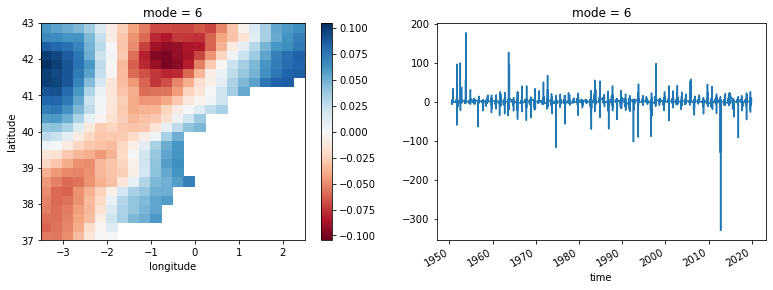

In [180]:
xU_dana = xr.DataArray(U_vlc_dana, dims=['x', 'mode'], coords={'x': vlc_prcp.coords['x'], 'mode': range(1, U_vlc_dana.shape[0] + 1)}).unstack()
xV_dana = xr.DataArray(V_vlc_dana, dims=['time', 'mode'], coords={'time': dana_date, 'mode': range(1, V_vlc_dana.shape[1] + 1)}).unstack()

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 5
xU_dana.sortby(['latitude', 'longitude']).isel(mode=mode).plot(ax=ax1, cmap='RdBu')
xV_dana.isel(mode=mode).plot(ax=ax2)
plt.show()

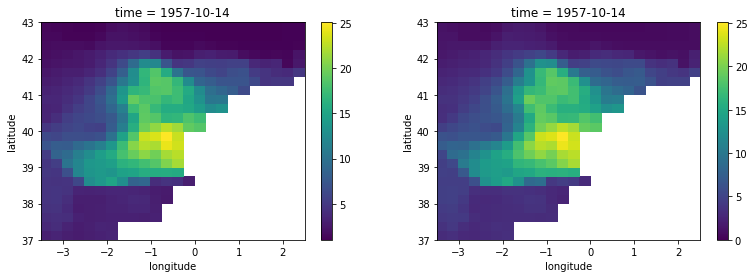

In [181]:
xdana_tran = xr.DataArray(vlc_dana_tran, dims=['time', 'x'], coords={'time': dana_date, 'x': vlc_prcp.coords['x']}).unstack()

rec_alldays = xU_dana.dot(xV_dana)
rec_alldays_notnan = rec_alldays.stack(x=('latitude', 'longitude')).dropna('x') # daily precipitation over Spain

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_tran.sel(time='1957-10-14').plot(ax=ax1) # original data
rec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction
plt.show()

### U.S.A

In [38]:
observations = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/yujing-code/data/obs.RData')
longitude = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/yujing-code/data/long.RData')
latitude = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/yujing-code/data/lat.RData')
timeseries = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/yujing-code/data/time.RData')

observations = pd.Series(observations)
longitude = pd.Series(longitude)
latitude = pd.Series(latitude)
timeseries = pd.Series(timeseries)

obs = observations.values[0].astype(float)
long = longitude.values[0].astype(float)
lat = latitude.values[0].astype(float)
time = timeseries.values[0]

#### *(Principal Component Analysis).* U.S.A. Precipitation (for moving averaged data)

In [39]:
#USA_notnan_idx = USA_prcp.notnull().all(axis=0) 
aso_id = take_month(time.values[:, 0], np.array([8, 9, 10]))
aso_date = time.values[aso_id, 0]
data_aso = obs.loc[aso_id, :].fillna(0) # Data corresponding to the Hurricane season

aso_ave = ma(data_aso.values, k=3) # 3-day moving average

pca = PCA(aso_ave)
eeuu_projected = pca.projected(n_X=aso_ave.shape[1])
eeuu_eofs = pca.eofs(n_X=aso_ave.shape[1])
eeuu_reconstructed = pca.reconstructed(n_X=aso_ave.shape[1])

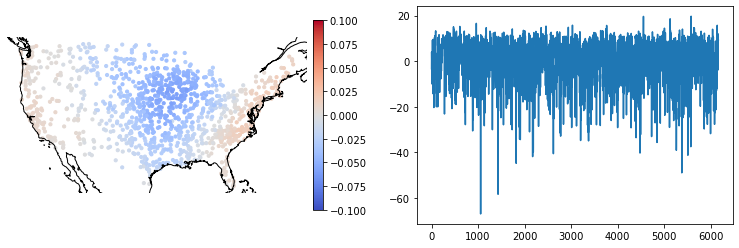

In [40]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121, projection=crs.Mercator())
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0.3)

mode = 0s
im = ax1.scatter(long.values, lat.values, c=eeuu_eofs[mode, :], s=10, transform=crs.PlateCarree(), cmap='coolwarm', vmin=-.1, vmax=.1)
plt.colorbar(im, ax=ax1, fraction=0.03, pad=0.02)
ax1.coastlines()
ax1.axis('off')
ax2.plot(np.arange(eeuu_projected.shape[0]), eeuu_projected[:, mode])
plt.show()

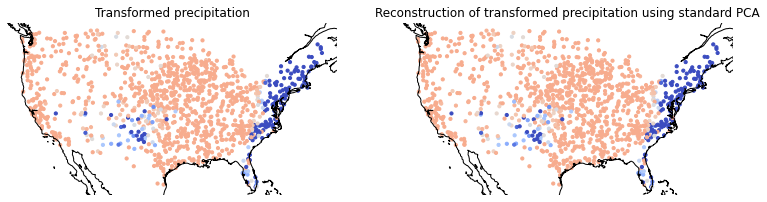

In [41]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121, projection=crs.Mercator())
ax2 = fig.add_subplot(122, projection=crs.Mercator())

ax1.scatter(long.values, lat.values, c=aso_ave[4555, :], s=10, vmin= -30, vmax=70, transform=crs.PlateCarree(), cmap='coolwarm_r')
ax1.coastlines()
ax1.axis('off')
ax1.set_title("Transformed precipitation")
ax2.scatter(long.values, lat.values, c=eeuu_reconstructed[4555, :], s=10, vmin= -30, vmax=70, transform=crs.PlateCarree(), cmap='coolwarm_r')
ax2.coastlines()
ax2.axis('off')
ax2.set_title("Reconstruction of transformed precipitation using standard PCA")
plt.show()

#### *(Principal Component Analysis for Extremes).* U.S Precipitation

In [47]:
## Code for computing Tail Pairwise Dependence Matrix (TPDM)

## For Hurricane season data (August, September, October). Calculate TPDM, its eigen decomposition and other quantities like principal components

aso_id = take_month(time.values[:, 0], np.array([8, 9, 10]))
aso_date = time.values[aso_id, 0]
data_aso = obs.loc[aso_id, :] # Data corresponding to the Hurricane season

aso_ave = ma(data_aso.values, k=3) # 3-day moving average
aso_smo = ECDF_smoothing(aso_ave, k=3) # ECDF smoothing
aso_tran = to_alpha_2(aso_smo) # Transfer the margins to have the same regular variation index: 2

sigma_aso = rw_Sigma(aso_tran) # Compute the TPDM
eigen_val, eigen_vec = np.linalg.eigh(sigma_aso) # Eigen decomposition of TPDM
idx = np.argsort(eigen_val)[::-1] # Sort eigenvalues and eigenvectors in ascending order
eigen_val = eigen_val[idx]
eigen_vec = eigen_vec[:, idx]
sign_eigenvectors = np.sign(eigen_vec[0, :])
eigen_vec *= sign_eigenvectors

U_aso = - eigen_vec # Basis vectors for PCA of TPDM
aso_tran_inv = inv_trans(aso_tran) # Inverse transformation
V_aso = pc(U_aso, aso_tran_inv) # Each column is a principal component
N = V_aso.shape[0]

##########################################################################################################
##########################################################################################################

## To plot basis vectors and reconstructions
long_aso = long.values[:, 0]
lat_aso = lat.values[:, 0]

## To plot time series of PCs with El Niño and La Niña and ENSO-medium periods added
enso = pd.read_csv('/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/yujing-code/data/enso.txt', sep='\t').set_index('Year')

conditions = [
    (enso.ASO <= -0.5),
    ((enso.ASO > -0.5) & (enso.ASO <= 0.5)),
    (enso.ASO > 0.5)]
values = ['low', 'medium', 'high']
enso['ENSO'] = np.select(conditions, values)

## Prepare year break for the time series of PC plot.
aso_mon, aso_yr = take_month_year(aso_date)

yr_st = np.repeat(0, len(enso.index) - 1) # 67: From 1951 - 2016
aso_yr_u = np.unique(aso_yr).astype(int)
for YR in range(len(enso.index) - 1):
    yr_st[YR] = np.where(aso_yr == aso_yr_u[YR])[0][0]

yr_bk = np.repeat(0, 3)
yri = 0
for YR in [1960, 1980, 2000]:
    yr_bk[yri] = np.where(aso_yr == YR)[0][0]
    yri += 1
yr_bk

mon_st = np.repeat(0, len(enso.index) - 1)
j = 0
for YR in range(len(enso.index) - 1):
    mon_st[j] = np.where((aso_yr == aso_yr_u[YR]) & (np.isin(aso_mon, np.array([8, 9, 10]))))[0][0]
    j += 1

enso['start'] = np.append(mon_st, np.nan)
enso['end'] = np.append(np.append(mon_st[1:] - 1, len(aso_yr)) - 1, np.nan)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [48]:
#Save data, as it takes too much time to compile the code
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-aso_tran.RData", pd.DataFrame(aso_tran), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-sigma_aso.RData", pd.DataFrame(sigma_aso), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-U_aso.RData", pd.DataFrame(U_aso), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-xpca/python-data/python-V_aso.RData", pd.DataFrame(V_aso), compress="gzip")

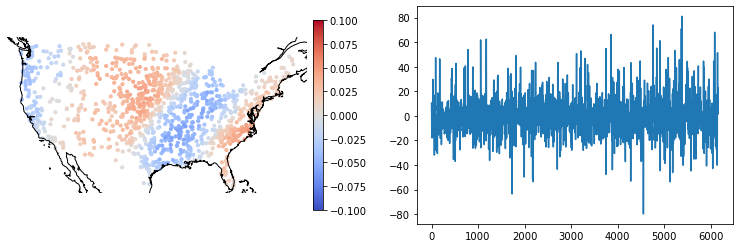

In [49]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121, projection=crs.Mercator())
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0.3)

mode = 3
im  = ax1.scatter(long.values, lat.values, c=U_aso[:, mode], s=10, transform=crs.PlateCarree(), cmap='coolwarm', vmin=-.1, vmax=.1)
plt.colorbar(im, ax=ax1, fraction=0.03, pad=0.02)
ax1.coastlines()
#ax1.set_title('Seventh principal component')
ax1.axis('off')

ax2.plot(np.arange(V_aso.shape[0]), -V_aso[:, mode])
#ax2.set_title('Times series of the seventh principal component scores')
plt.show()

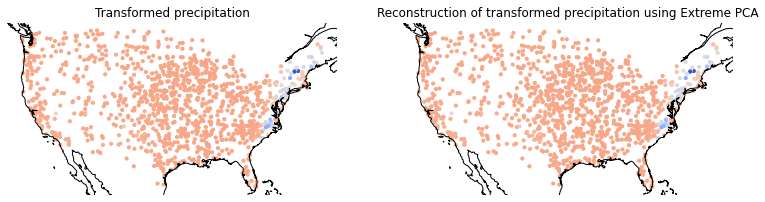

In [50]:
rec = reconstruct(V_aso, U_aso, 1140, 4555)

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121, projection=crs.Mercator())
ax2 = fig.add_subplot(122, projection=crs.Mercator())

ax1.scatter(long.values, lat.values, c=aso_tran[4555, :], s=10, transform=crs.PlateCarree(), vmin= -30, vmax=80, cmap='coolwarm_r')
ax1.coastlines()
ax1.set_title('Transformed precipitation')
ax1.axis('off')

ax2.scatter(long.values, lat.values, c=rec, s=10, transform=crs.PlateCarree(), vmin= -30, vmax=80, cmap='coolwarm_r')
ax2.coastlines()
ax2.axis('off')
ax2.set_title('Reconstruction of transformed precipitation using Extreme PCA')

plt.show()

### Understanding Maximum Covariance Analysis

In [222]:
###### Making sure MCA works as PCA if input is data repeated.

In [223]:
spain = ds.sel(latitude=slice(34, 45), longitude=slice(-10, 5)) # region of Spain
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
spain_notnan_idx = spain_prcp.notnull().all(axis=0)
spain_prcp = spain_prcp[:, spain_notnan_idx]

df_spain = spain_prcp.to_dataframe()
obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))

dana_id = take_month(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = spain_prcp.time.values[dana_id]
spain_data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Spain

spain_dana_ave = ma(spain_data_dana.values, k=3) # 3-day moving average
#spain_dana_smo = ECDF_smoothing(spain_dana_ave, k=3) # ECDF smoothing
#spain_dana_tran = to_alpha_2(spain_dana_smo) # Transfer the margins to have the same regular variation index: 2

mca = MCA(spain_dana_ave, spain_dana_ave)
spain_dana_projectedX, spain_dana_projectedY = mca.projected(spain_dana_ave.shape[1], spain_dana_ave.shape[1])
spain_dana_eofsX, spain_dana_eofsY = mca.eofs(spain_dana_ave.shape[1], spain_dana_ave.shape[1])

#spain_dana_projectedX, spain_dana_projectedY = MCA_projected(spain_data_dana.values, spain_data_dana.values, spain_data_dana.shape[1], spain_data_dana.shape[1])
#spain_dana_eofsX, spain_dana_eofsY = MCA_eofs(spain_data_dana.values, spain_data_dana.values, spain_data_dana.shape[1], spain_data_dana.shape[1])

da = xr.DataArray(spain_dana_eofsY, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, spain_dana_eofsY.shape[0] + 1)})
da = da.unstack().sortby(['longitude', 'latitude'])

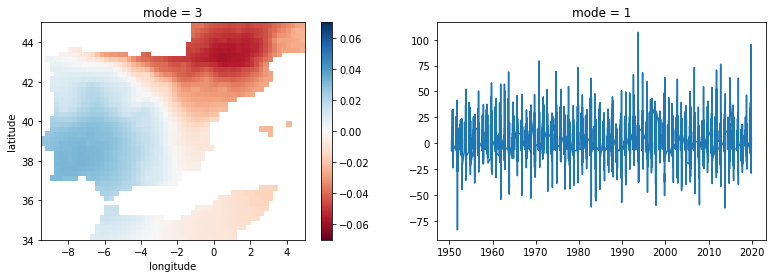

In [224]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 3
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(dana_date, - spain_dana_projectedY[:, mode - 1])
ax2.set_title('mode = 1')
plt.show()

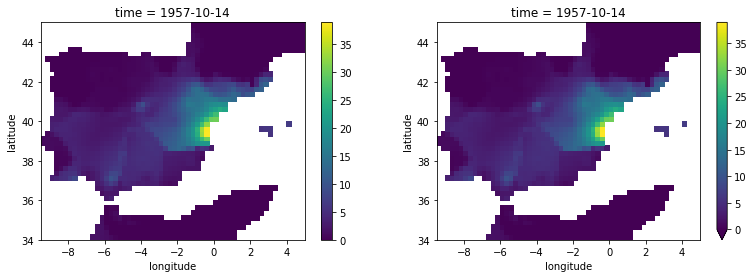

In [225]:
#xdana_tran = xr.DataArray(spain_dana_tran, dims=['time', 'x'], coords={'time': dana_date, 'x': spain_prcp.coords['x']}).unstack()
xdana_ma = xr.DataArray(spain_dana_ave, dims=['time', 'x'], coords={'time': dana_date, 'x': spain_prcp.coords['x']}).unstack()

rec_alldays = np.dot(spain_dana_projectedY, spain_dana_eofsY) * np.std(spain_dana_ave, axis=0) + np.mean(spain_dana_ave, axis=0)
xrec_alldays = xr.DataArray(rec_alldays, dims=['time', 'x'], coords={'x': spain_prcp.coords['x'], 'time': spain.time[spain.time.dt.month.isin([7, 8, 9, 10, 11])].values})
xrec_alldays = xrec_alldays.unstack().sortby(['longitude', 'latitude'])

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xdana_ma.unstack().sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax1) # transformed precipitation data
xrec_alldays.sel(time='1957-10-14').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of transformed precipitation
plt.show()

### SSS-multiobs

In [287]:
file = '/Users/miguel/Desktop/fisica_mates/cinque/tfg-xpca/data/sss-multiobs.nc'
dsss = xr.open_dataset(file)
dsss_coarsed = dsss.sos.coarsen({'lon': 3, 'lat': 3}, boundary='trim').mean()
dsss

<xarray.Dataset>
Dimensions:  (lat: 280, lon: 600, time: 1408)
Coordinates:
    depth    float32 ...
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 69.12 69.38 69.62 69.88
  * lon      (lon) float32 -99.88 -99.62 -99.38 -99.12 ... 49.38 49.62 49.88
  * time     (time) datetime64[ns] 1993-01-06T12:00:00 ... 2019-12-25T12:00:00
Data variables:
    sos      (time, lat, lon) float32 ...

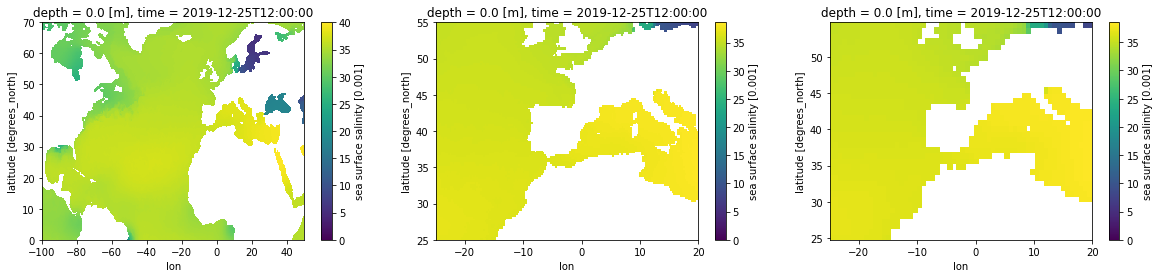

In [288]:
fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

dsss.sel(time='2019-12-25').sos.plot(ax=ax1, vmin=0)
dsss.sel(time='2019-12-25', lat=slice(25, 55), lon=slice(-25, 20)).sos.plot(ax=ax2, vmin=0)
dsss_coarsed.sel(time='2019-12-25', lat=slice(25, 55), lon=slice(-25, 20)).plot(ax=ax3, vmin=0)
plt.show()

In [17]:
def remove_seasonal_signal(da):
    weekly_groups = da.time.dt.isocalendar().week
    return da.groupby(weekly_groups) - da.groupby(weekly_groups).mean()

### Spain-Sea Surface Salinity

#### *(Maximum Covariance Analysis).* Spain Weekly Precipitation and Sea Surface Salinity

In [289]:
# Precipitation
spain = ds.sel(latitude=slice(34, 45), longitude=slice(-10, 5)).resample({'time' : 'w'}).sum() # region of Spain
spain = (spain - spain.mean('time')) / spain.std('time')
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
_, year_spain = take_month_year(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'))
spain_prcp = spain_prcp[np.where((year_spain >= 1993) & (year_spain <= 2019))].resample({'time' : 'w'}).sum()[:-1] # weekly precipitation over Spain from 1993 to 2019
spain_notnan_idx = spain_prcp.notnull().any(axis=0)
spain_prcp = spain_prcp[:, spain_notnan_idx]
spain_std_idx = spain_prcp.std('time') > 1e-8
spain_prcp = spain_prcp[:, spain_std_idx]
#spain_prcp = remove_seasonal_signal(spain_prcp)

#df_spain = spain_prcp.to_dataframe()
#obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))
#spain_data_dana = obs # Data corresponding to the Cold Drop season in Spain

# Sea surface salinity
sss = dsss_coarsed.sel(lat=slice(25, 55), lon=slice(-25, 20)) # small region covering Atlantic ocean and the Mediterranean sea
sss = (sss - sss.mean('time')) / sss.std('time')
sss_sos = sss.stack(x=('lat', 'lon')) # weekly sea surface salinity over a small region of the Atlantic ocean and the Mediterranean sea from 1993 to 2019
sss_notnan_idx = sss_sos.notnull().any(axis=0)
sss_sos = sss_sos[:, sss_notnan_idx]
sss_std_idx = sss_sos.std('time') > 1e-8
sss_sos = sss_sos[:, sss_std_idx]
sss_sos = remove_seasonal_signal(sss_sos)

#df_sss = sss_sos.to_dataframe()
#obs_sss = pd.DataFrame(df_sss.droplevel(level=[1,2]).sos.values.reshape(sss_sos.time.shape[0], sss_sos.x.shape[0]))
#sss_data_dana = obs_sss # Data corresponding to sea surface salinity during the Cold Drop season in Spain

In [290]:
# Maximum covariance analysis
mca = MCA(spain_prcp.values, sss_sos.values)
spain_dana_projected, sss_dana_projected = mca.projected(spain_prcp.shape[1], sss_sos.shape[1])
spain_dana_eofs, sss_dana_eofs = mca.eofs(spain_prcp.shape[1], sss_sos.shape[1])

da_prcp = xr.DataArray(spain_dana_eofs, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, spain_dana_eofs.shape[0] + 1)})
da_prcp = da_prcp.unstack().sortby(['longitude', 'latitude'])

da_sss = xr.DataArray(sss_dana_eofs, dims=['mode', 'x'], coords={'x': sss_sos.coords['x'], 'mode': range(1, sss_dana_eofs.shape[0] + 1)})
da_sss = da_sss.unstack().sortby(['lon', 'lat'])

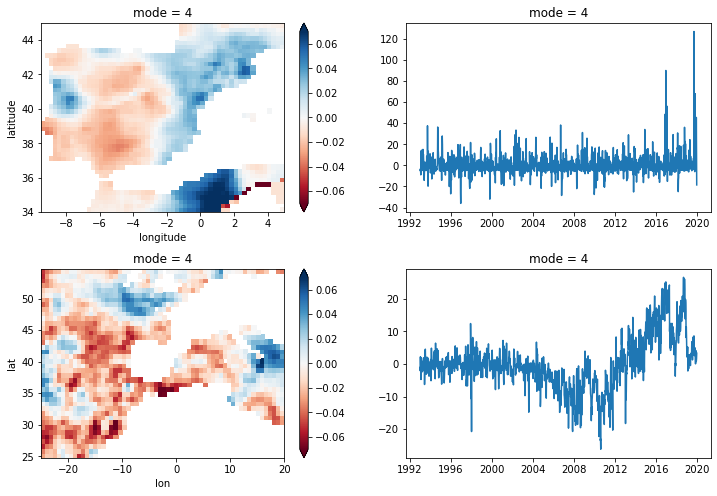

In [291]:
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

mode = 4
da_prcp.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(spain_prcp.time, spain_dana_projected[:, mode - 1])
ax2.set_title('mode = {:}'.format(mode))

da_sss.sel(mode=mode, lat=slice(25, 55), lon=slice(-25, 20)).plot(ax=ax3, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax4.plot(sss_sos.time, sss_dana_projected[:, mode - 1])
ax4.set_title('mode = {:}'.format(mode))

plt.show()

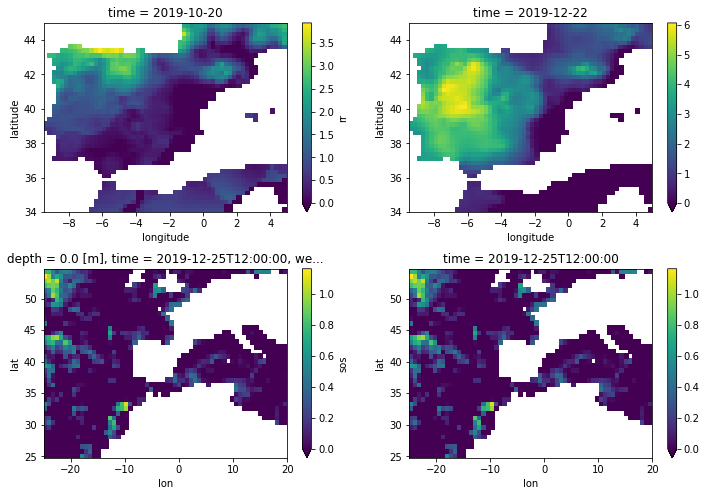

In [292]:
rec_alldays_prcp = np.dot(spain_dana_projected, spain_dana_eofs) * np.std(spain_prcp.values, axis=0) + np.mean(spain_prcp.values, axis=0)
xrec_alldays_prcp = xr.DataArray(rec_alldays_prcp, dims=['time', 'x'], coords={'x': spain_prcp.coords['x'], 'time': spain_prcp.time.values})
xrec_alldays_prcp = xrec_alldays_prcp.unstack().sortby(['longitude', 'latitude'])

rec_alldays_sss = np.dot(sss_dana_projected, sss_dana_eofs) * np.std(sss_sos.values, axis=0) + np.mean(sss_sos.values, axis=0)
xrec_alldays_sss = xr.DataArray(rec_alldays_sss, dims=['time', 'x'], coords={'x': sss_sos.coords['x'], 'time': sss_sos.time.values})
xrec_alldays_sss = xrec_alldays_sss.unstack().sortby(['lat', 'lon'])

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

spain_prcp.unstack().sel(time='2019-10-20').sortby(['latitude', 'longitude']).plot(ax=ax1, vmin=0) # precipitation data
xrec_alldays_prcp.sel(time='2019-12-22').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of precipitation
sss_sos.unstack().sel(time='2019-12-25').sortby(['lat', 'lon']).plot(ax=ax3, vmin=0) # sea surface salinity data
xrec_alldays_sss.sel(time='2019-12-25').sortby(['lat', 'lon']).plot(ax=ax4, vmin=0) # reconstruction of sea surface salinity

plt.show()

#### *(Maximum Covariance Analysis).* Spain Precipitation and Sea Surface Salinity (for moving averaged data)

In [45]:
# Precipitation
spain = ds.sel(latitude=slice(34, 45), longitude=slice(-10, 5)).resample({'time' : 'w'}).sum() # region of Spain
spain = (spain - spain.mean('time')) / spain.std('time')
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
_, year_spain = take_month_year(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'))
spain_prcp = spain_prcp[np.where((year_spain >= 1993) & (year_spain <= 2019))].resample({'time' : 'w'}).sum()[:-1] # weekly precipitation over Spain from 1993 to 2019
spain_notnan_idx = spain_prcp.notnull().any(axis=0)
spain_prcp = spain_prcp[:, spain_notnan_idx]
spain_std_idx = spain_prcp.std('time') > 1e-8
spain_prcp = spain_prcp[:, spain_std_idx]
spain_prcp = remove_seasonal_signal(spain_prcp)

df_spain = spain_prcp.to_dataframe()
obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).rr.values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))
spain_data_dana = obs

spain_dana_ave = ma(spain_data_dana.values, k=3) # 3-day moving average

# Sea surface salinity
sss = dsss_coarsed.sel(lat=slice(25, 55), lon=slice(-25, 20)) # small region covering Atlantic ocean and the Mediterranean sea
sss_sos = sss.stack(x=('lat', 'lon')) # weekly sea surface salinity over a small region of the Atlantic ocean and the Mediterranean sea from 1993 to 2019
sss_notnan_idx = sss_sos.notnull().all(axis=0)
sss_sos = sss_sos[:, sss_notnan_idx]
sss_std_idx = sss_sos.std('time') > 1e-8
sss_sos = sss_sos[:, sss_std_idx]
sss_sos = remove_seasonal_signal(sss_sos)

df_sss = sss_sos.to_dataframe()
obs_sss = pd.DataFrame(df_sss.droplevel(level=[1,2]).sos.values.reshape(sss_sos.time.shape[0], sss_sos.x.shape[0]))
sss_data_dana = obs_sss

sss_dana_ave = ma(sss_data_dana.values, k=3) # 3-day moving average

In [46]:
# Maximum covariance analysis
mca = MCA(spain_dana_ave, sss_dana_ave)
spain_dana_projected, sss_dana_projected = mca.projected(spain_dana_ave.shape[1], sss_dana_ave.shape[1])
spain_dana_eofs, sss_dana_eofs = mca.eofs(spain_dana_ave.shape[1], sss_dana_ave.shape[1])

da_prcp = xr.DataArray(spain_dana_eofs, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, spain_dana_eofs.shape[0] + 1)})
da_prcp = da_prcp.unstack().sortby(['longitude', 'latitude'])

da_sss = xr.DataArray(sss_dana_eofs, dims=['mode', 'x'], coords={'x': sss_sos.coords['x'], 'mode': range(1, sss_dana_eofs.shape[0] + 1)})
da_sss = da_sss.unstack().sortby(['lon', 'lat'])

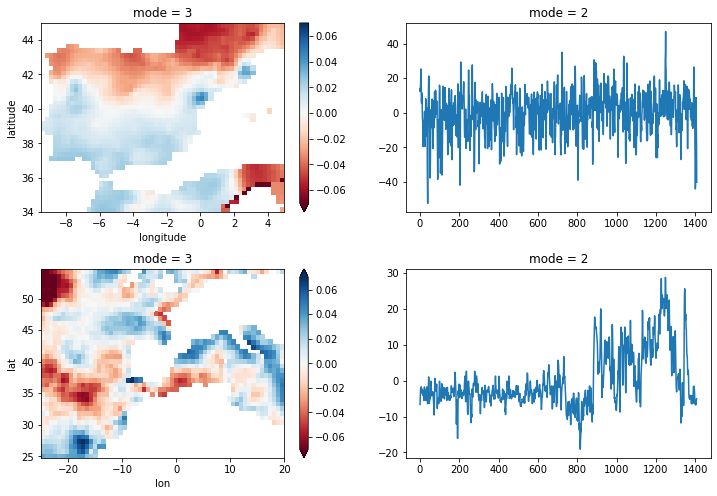

In [47]:
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

mode = 3
da_prcp.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(range(spain_dana_projected.shape[0]), spain_dana_projected[:, mode - 1])
ax2.set_title('mode = 2')

da_sss.sel(mode=mode, lat=slice(25, 55), lon=slice(-25, 20)).plot(ax=ax3, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax4.plot(range(sss_dana_projected.shape[0]), sss_dana_projected[:, mode - 1])
ax4.set_title('mode = 2')

plt.show()

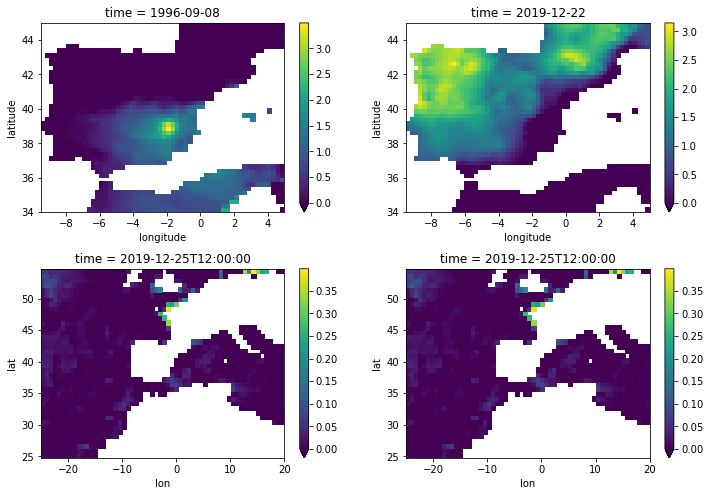

In [67]:
x_spain_dana_ave = xr.DataArray(spain_dana_ave, dims=['time', 'x'], coords={'time': spain_prcp.time.values, 'x': spain_prcp.coords['x']}).unstack()
x_sss_dana_ave = xr.DataArray(sss_dana_ave, dims=['time', 'x'], coords={'time': sss_sos.time.values, 'x': sss_sos.coords['x']}).unstack()

rec_alldays_prcp = np.dot(spain_dana_projected, spain_dana_eofs) * np.std(spain_dana_ave, axis=0) + np.mean(spain_dana_ave, axis=0)
xrec_alldays_prcp = xr.DataArray(rec_alldays_prcp, dims=['time', 'x'], coords={'x': spain_prcp.coords['x'], 'time': spain_prcp.time.values})
xrec_alldays_prcp = xrec_alldays_prcp.unstack().sortby(['longitude', 'latitude'])

rec_alldays_sss = np.dot(sss_dana_projected, sss_dana_eofs) * np.std(sss_dana_ave, axis=0) + np.mean(sss_dana_ave, axis=0)
xrec_alldays_sss = xr.DataArray(rec_alldays_sss, dims=['time', 'x'], coords={'x': sss_sos.coords['x'], 'time': sss_sos.time.values})
xrec_alldays_sss = xrec_alldays_sss.unstack().sortby(['lat', 'lon'])

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x_spain_dana_ave.unstack().sel(time='1996-09-08').sortby(['latitude', 'longitude']).plot(ax=ax1, vmin=0) # precipitation transformed data
xrec_alldays_prcp.sel(time='2019-12-22').sortby(['latitude', 'longitude']).plot(ax=ax2, vmin=0) # reconstruction of transformed precipitation
x_sss_dana_ave.unstack().sel(time='2019-12-25').sortby(['lat', 'lon']).plot(ax=ax3, vmin=0) # sea surface salinity transformed data
xrec_alldays_sss.sel(time='2019-12-25').sortby(['lat', 'lon']).plot(ax=ax4, vmin=0) # reconstruction of transformed sea surface salinity 

plt.show()

In [62]:
spain_prcp.time[spain_prcp.time.dt.year.isin([1996])]

<xarray.DataArray 'time' (time: 52)>
array(['1996-01-07T00:00:00.000000000', '1996-01-14T00:00:00.000000000',
       '1996-01-21T00:00:00.000000000', '1996-01-28T00:00:00.000000000',
       '1996-02-04T00:00:00.000000000', '1996-02-11T00:00:00.000000000',
       '1996-02-18T00:00:00.000000000', '1996-02-25T00:00:00.000000000',
       '1996-03-03T00:00:00.000000000', '1996-03-10T00:00:00.000000000',
       '1996-03-17T00:00:00.000000000', '1996-03-24T00:00:00.000000000',
       '1996-03-31T00:00:00.000000000', '1996-04-07T00:00:00.000000000',
       '1996-04-14T00:00:00.000000000', '1996-04-21T00:00:00.000000000',
       '1996-04-28T00:00:00.000000000', '1996-05-05T00:00:00.000000000',
       '1996-05-12T00:00:00.000000000', '1996-05-19T00:00:00.000000000',
       '1996-05-26T00:00:00.000000000', '1996-06-02T00:00:00.000000000',
       '1996-06-09T00:00:00.000000000', '1996-06-16T00:00:00.000000000',
       '1996-06-23T00:00:00.000000000', '1996-06-30T00:00:00.000000000',
       '1996-07-07T00:00:00.000000000', '1996-07-14T00:00:00.000000000',
       '1996-07-21T00:00:00.000000000', '1996-07-28T00:00:00.000000000',
       '1996-08-04T00:00:00.000000000', '1996-08-11T00:00:00.000000000',
       '1996-08-18T00:00:00.000000000', '1996-08-25T00:00:00.000000000',
       '1996-09-01T00:00:00.000000000', '1996-09-08T00:00:00.000000000',
       '1996-09-15T00:00:00.000000000', '1996-09-22T00:00:00.000000000',
       '1996-09-29T00:00:00.000000000', '1996-10-06T00:00:00.000000000',
       '1996-10-13T00:00:00.000000000', '1996-10-20T00:00:00.000000000',
       '1996-10-27T00:00:00.000000000', '1996-11-03T00:00:00.000000000',
       '1996-11-10T00:00:00.000000000', '1996-11-17T00:00:00.000000000',
       '1996-11-24T00:00:00.000000000', '1996-12-01T00:00:00.000000000',
       '1996-12-08T00:00:00.000000000', '1996-12-15T00:00:00.000000000',
       '1996-12-22T00:00:00.000000000', '1996-12-29T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1996-01-07 1996-01-14 ... 1996-12-29
    week     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 43 44 45 46 47 48 49 50 51 52

#### *(Extreme Maximum Covariance Analysis).* Spain Precipitation and Sea Surface Salinity

In [168]:
# Precipitation
spain = ds.sel(latitude=slice(34, 45), longitude=slice(-10, 5)).resample({'time' : 'w'}).sum() # region of Spain
spain = (spain - spain.mean('time')) / spain.std('time')
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
_, year_spain = take_month_year(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'))
spain_prcp = spain_prcp[np.where((year_spain >= 1993) & (year_spain <= 2019))].resample({'time' : 'w'}).sum()[:-1] # weekly precipitation over Spain from 1993 to 2019
spain_notnan_idx = spain_prcp.notnull().any(axis=0)
spain_prcp = spain_prcp[:, spain_notnan_idx]
spain_std_idx = spain_prcp.std('time') > 1e-8
spain_prcp = spain_prcp[:, spain_std_idx]
spain_prcp = remove_seasonal_signal(spain_prcp)

df_spain = spain_prcp.to_dataframe()
obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).rr.values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))
spain_data_dana = obs

spain_dana_ave = ma(spain_data_dana.values, k=3) # 3-day moving average
spain_dana_smo = ECDF_smoothing(spain_dana_ave, k=3) # ECDF smoothing
spain_dana_tran = to_alpha_2(spain_dana_smo) # Transfer the margins to have the same regular variation index: 2

# Sea surface salinity
sss = dsss_coarsed.sel(lat=slice(25, 55), lon=slice(-25, 20)) # small region covering Atlantic ocean and the Mediterranean sea
sss_sos = sss.stack(x=('lat', 'lon')) # weekly sea surface salinity over a small region of the Atlantic ocean and the Mediterranean sea from 1993 to 2019
sss_notnan_idx = sss_sos.notnull().all(axis=0)
sss_sos = sss_sos[:, sss_notnan_idx]
sss_std_idx = sss_sos.std('time') > 1e-8
sss_sos = sss_sos[:, sss_std_idx]
sss_sos = remove_seasonal_signal(sss_sos)

df_sss = sss_sos.to_dataframe()
obs_sss = pd.DataFrame(df_sss.droplevel(level=[1,2]).sos.values.reshape(sss_sos.time.shape[0], sss_sos.x.shape[0]))
sss_data_dana = obs_sss

sss_dana_ave = ma(sss_data_dana.values, k=3) # 3-day moving average
sss_dana_smo = ECDF_smoothing(sss_dana_ave, k=3) # ECDF smoothing
sss_dana_tran = to_alpha_2(sss_dana_smo) # Transfer the margins to have the same regular variation index: 2

In [169]:
def rw_Sigma_nondecls(x, y, u=0.80):
    Sigma = np.zeros((x.shape[1], y.shape[1]))
    r = np.sqrt(x.T[:, np.newaxis] ** 2 + y.T ** 2)
    w1 = x.T[:, np.newaxis] / r
    w2 = y.T[np.newaxis, :] / r
    idx = np.where(r > np.nanquantile(r, u))
    Sigma = np.nansum(w1[idx] * w2[idx]) / 7 * 2
    
    return Sigma

In [ ]:
sigma_spain_sss = rw_Sigma_nondecls(spain_dana_tran, sss_dana_tran)

In [60]:
X_eofs, eigen_val, Y_eofs = np.linalg.svd(sigma_spain_sss) # Eigen decomposition of TPDM
Y_eofs = Y_eofs.T
idx_X = np.argsort(X_eofs)[::-1] # Sort eigenvalues and eigenvectors in ascending order
idx_Y = np.argsort(Y_eofs)[::-1] 
X_eofs = X_eofs[:, idx_X] * np.sign(X_eofs[0, :])
Y_eofs = Y_eofs[:, idx_Y] * np.sign(Y_eofs[0, :])

U_spain = - X_eofs # Basis vectors for PCA of TPDM
spain_tran_inv = inv_trans(spain_dana_tran) # Inverse transformation
V_spain = pc(U_aso, spain_tran_inv) # Each column is a principal component
N = V_spain.shape[0]

U_sss = - Y_eofs # Basis vectors for PCA of TPDM
sss_tran_inv = inv_trans(sss_dana_tran) # Inverse transformation
V_sss = pc(U_sss, sss_tran_inv) # Each column is a principal component
N = V_sss.shape[0]

NameError: name 'sss_dana_tran' is not defined

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

mode = 4
da_prcp.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax2.plot(spain_prcp.time, spain_dana_projected[:, mode - 1])
ax2.set_title('mode = {:}'.format(mode))

da_sss.sel(mode=mode, lat=slice(25, 55), lon=slice(-25, 20)).plot(ax=ax3, cmap='RdBu', vmin=-0.07, vmax=0.07)
ax4.plot(sss_sos.time, sss_dana_projected[:, mode - 1])
ax4.set_title('mode = {:}'.format(mode))

plt.show()

In [6]:
import numpy as np
a = np.random.randn(6000, 6000)
X_eofs, eigen_val, Y_eofs = np.linalg.svd(a) # Eigen decomposition of TPDM

### Trying to speed up the TPDM

In [ ]:
import timeit

In [ ]:
def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    id_res = np.repeat(0, start.shape[0])
    for i in range(len(start)):
        temp = x.T.flatten()[start[i]:end[i] + 1]
        id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1
    
    return id_res


def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            r = np.sqrt(x[:, i] ** 2 + x[:, j] ** 2)
            w1 = x[:, i] / r
            w2 = x[:, j] / r
            idx = decls(r, th = np.nanquantile(r, u), k = 5)
            Sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2
    
    return Sigma


def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    idx = np.logical_and(np.arange(x.T.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
    ext_prcp = x.T.flatten()[np.sum(idx * 1, axis=0).astype(bool)]
    cls_prcp = np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1])

    return list(map(np.nanargmax, cls_prcp)) + start


def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    r = np.sqrt(x.T[:, np.newaxis] ** 2 + x.T ** 2)
    w1 = x.T[:, np.newaxis] / r
    w2 = x.T[np.newaxis, :] / r
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            idx = decls(r[i,j], th = np.nanquantile(r[i,j], u), k = 5)
            Sigma[i, j] = np.nansum(w1[i,j,idx] * w2[i,j,idx]) / len(idx) * 2
    
    return Sigma

### Just a small silly toy dataset

In [182]:
x = np.array([[6, 10, 3, np.nan, 5, 9, 11, 1, 1, 10],
              [12, 7, 1, 9, 4, 6, np.nan, 1, 11, 11],
              [1, 8, 1, 3, 12, 9, 10, 2, 7, 5],
              [8,  np.nan, 1, 3, 12,  10, 10, 2, 7, 5]]).astype(float) 
x = x.T
x

array([[ 6., 12.,  1.,  8.],
       [10.,  7.,  8., nan],
       [ 3.,  1.,  1.,  1.],
       [nan,  9.,  3.,  3.],
       [ 5.,  4., 12., 12.],
       [ 9.,  6.,  9., 10.],
       [11., nan, 10., 10.],
       [ 1.,  1.,  2.,  2.],
       [ 1., 11.,  7.,  7.],
       [10., 11.,  5.,  5.]])

In [82]:
def decls(x, th, k):
    # Minimum number of days to define extreme event
    n_days = 3
    # Define extreme event quantile
    thr_quantile = 0.90
    threshold = np.nanquantile(x, thr_quantile)
    print(np.convolve(x >= threshold, np.ones(n_days), 'valid'))
    # Use convolution with a window function of length = number of days to decluster the extreme events
    idx_extremes = np.flatnonzero(np.convolve(x >= threshold, np.ones(n_days), 'valid') >= n_days)
    print(idx_extremes)
    # The index currently contains only the first days (start) of an extreme event
    # Add all indices for days which qualilfy as extreme
    idx_extremes = [idx_extremes + i for i in range(n_days)]
    idx_extremes = reduce(np.union1d, (idx_extremes))
    # Create a boolean index from the extreme index which we can use to
    # mask the original data
    idx_all = np.arange(len(x))
    idx_extremes = np.where(np.isin(idx_all, idx_extremes), True, False)

    return np.where(idx_extremes == True)[0]

In [167]:
# Minimum number of days to define extreme event
n_days = 3
# Define extreme event quantile
thr_quantile = 0.90
# Some toy data including one correct extreme event and two incorrect
# (too short) event

data = np.array([
    0, 1, 1, 0, 0, 5, 5, 5, 0, 5, 5, 5, 5, 0, 5, 5, 5, 0, 0
])
threshold = np.quantile(data, thr_quantile)

# Use convolution with a window function of length = number of days
# to decluster the extreme events
# This approach should be much faster than using for loops
idx_extremes = np.flatnonzero(np.convolve(data >= threshold, np.ones(n_days), 'valid') >= n_days)

# The index currently contains only the first days (start) of an extreme event
# Add all indices for days which qualilfy as extreme
idx_extremes = [idx_extremes + i for i in range(n_days)]
idx_extremes = reduce(np.union1d, (idx_extremes))
print(idx_extremes)
(idx_extremes[np.append(0, np.where(np.diff(idx_extremes) > 1)[0] + 1)])

# Create a boolean index from the extreme index which we can use to
# mask the original data
idx_all = np.arange(len(data))
idx_extremes = np.where(np.isin(idx_all, idx_extremes), True, False)
print(idx_extremes)
# Example: we mask out all non-extreme events
print('All data: ', data)
print('Only extremes: ', data[idx_extremes])

#return np.where(idx_extremes == True)[0]

[ 5  6  7  9 10 11 12 14 15 16]
[ 5  9 14]
[False False False False False  True  True  True False  True  True  True
  True False  True  True  True False False]
All data:  [0 1 1 0 0 5 5 5 0 5 5 5 5 0 5 5 5 0 0]
Only extremes:  [5 5 5 5 5 5 5 5 5 5]


In [193]:
def decls(x, th, k):
    # Minimum number of days to define extreme event
    n_days = k
    # Define extreme event quantile
    thr_quantile = 0.90

    threshold = np.quantile(data, thr_quantile)

    # Use convolution with a window function of length = number of days
    # to decluster the extreme events
    # This approach should be much faster than using for loops
    idx_extremes = np.flatnonzero(np.convolve(x.flatten() >= threshold, np.ones(n_days), 'valid') >= n_days)

    # The index currently contains only the first days (start) of an extreme event
    # Add all indices for days which qualilfy as extreme
    idx_extremes = [idx_extremes + i for i in range(n_days)]
    idx_extremes = reduce(np.union1d, (idx_extremes))

    return idx_extremes[np.append(0, np.where(np.diff(idx_extremes) > 1)[0] + 1)]

In [194]:
decls(x, th=np.nanquantile(x,.9), k=3)

array([ 3, 18, 33])

In [197]:
def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    print(start)
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    print(end)
    id_res = np.repeat(0, start.shape[0])
    for i in range(len(start)):
        temp = x.T.flatten()[start[i]:end[i] + 1]
        id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1
    
    return id_res

decls(x, th=3, k=3)

[ 0  4  9 18 24 34]
[ 1  6 15 21 30 39]


array([ 1,  6, 10, 18, 24, 34])

In [ ]:
def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    idx = np.logical_and(np.arange(x.T.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
    ext_prcp = x.T.flatten()[np.sum(idx * 1, axis=0).astype(bool)]
    cls_prcp = np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1])

    return list(map(np.nanargmax, cls_prcp)) + start

decls(x, th=5, k=3)

In [ ]:
def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        print('\n')
        for j in range(x.shape[1]):
            r = np.sqrt(x[:, i] ** 2 + x[:, j] ** 2)
            print(r)
            w1 = x[:, i] / r
            w2 = x[:, j] / r
            idx = decls(r, th = np.nanquantile(r, u), k = 5)
            Sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2
    
    return Sigma

rw_Sigma(x)

In [ ]:
def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    r = np.sqrt(x.T[:, np.newaxis] ** 2 + x.T ** 2)
    w1 = x.T[:, np.newaxis] / r
    w2 = x.T[np.newaxis, :] / r
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            idx = decls(r[i,j], th = np.nanquantile(r[i,j], u), k = 5)
            Sigma[i, j] = np.nansum(w1[i,j,idx] * w2[i,j,idx]) / len(idx) * 2
    
    return Sigma

rw_Sigma(x)

In [ ]:
a = np.repeat(np.arange(0, 20, 1)[:, np.newaxis].T, 10, axis=0)
mask = a > 5

b = a.T[:, np.newaxis] + a.T
print(b.shape)
b.shape

c = (a**2).T @ a**2

In [ ]:
x.T.flatten()

In [ ]:
k = 3; th = 5

id_big = np.where(x.T.flatten() > th)[0]
start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
print
idx = np.logical_and(np.arange(x.T.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
print(idx)
ext_prcp = x.T.flatten()[np.sum(idx * 1, axis=0).astype(bool)]
cls_prcp = np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1])

list(map(np.nanargmax, cls_prcp)) + start

### Learning to use Basemap

In [132]:
from mpl_toolkits.basemap import Basemap

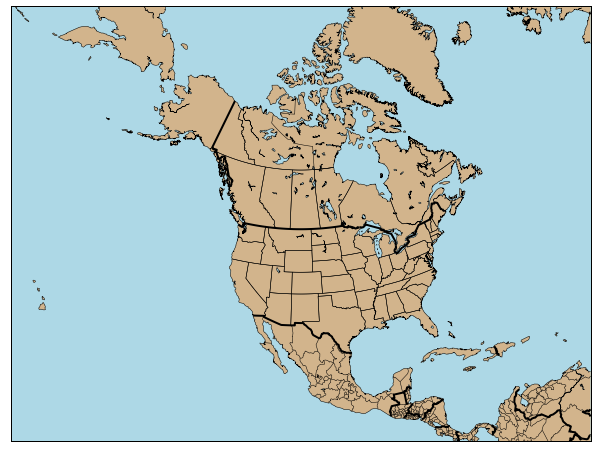

In [142]:
fig = plt.figure(figsize=(12, 8)) 
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='tan', lake_color='lightblue')
# draw parallels and meridians.
#m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False], dashes=[2,2])
#m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True], dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

plt.show()

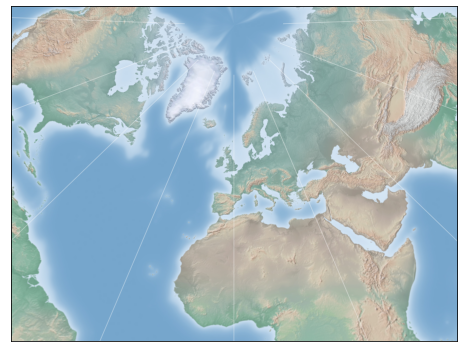

In [155]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-80, -40, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')



fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            lon_0=0, lat_0=50, lat_1=45, lat_2=55,
            width=1.6E7, height=1.2E7)
draw_map(m)